<a href="https://colab.research.google.com/github/GKD-stack/DSC180A-Methodology-1/blob/main/DSC180A_W4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!! pip install pandas_plink

In [ ]:
from pandas_plink import read_plink


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
fam_df_sorted[['fid','iid']].to_csv('/content/drive/My Drive/Colab Notebooks/individual_list.txt', sep='\t', index=False)


In [ ]:
# Assuming df_bim and df_fam are your filtered dataframes
fam_df_sorted.to_csv('/content/drive/My Drive/Colab Notebooks/filtered1.fam', sep='\t', index=False)
bim.to_csv('/content/drive/My Drive/Colab Notebooks/filtered1.bim', sep=' ', index=False)


In [ ]:
exp_agrn_sorted = df_transposed.sort_values(by='IID')
exp_agrn_sorted.to_csv("/content/drive/My Drive/Colab Notebooks/exp_agrn_sorted.txt", sep='\t', index=False)

In [ ]:
import pandas_plink as pdplink

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]
<ipython-input-6-9db48943b220>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  expression_df_filtered = agrn_vals[common_ids]


Yes


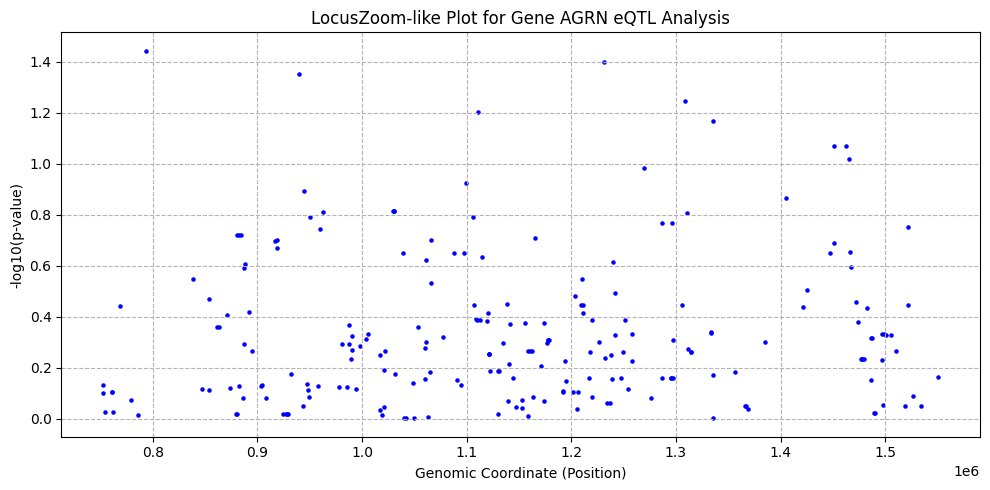

In [ ]:
# Load expression data
import pandas as pd
expr_data = pd.read_table("/content/drive/My Drive/Colab Notebooks/exp.txt", sep="\t")

#clean it just to get 1 gene
expr_data['TargetID_without_version'] = expr_data['TargetID'].str.split('.').str[0]
expr_data['Gene_Symbol_without_version'] = expr_data['Gene_Symbol'].str.split('.').str[0]
agrn_expr = expr_data[expr_data["Gene_Symbol_without_version"] == "ENSG00000188157"]
agrn_vals = agrn_expr.drop(columns=['TargetID','Gene_Symbol', 'Chr', 'Coord', 'TargetID_without_version', 'Gene_Symbol_without_version'])

#Load genotype data
(bim, fam, bed) = read_plink('/content/drive/My Drive/Colab Notebooks/1000G.EUR.1.AGRN')

#filter fam
fam_ids = fam['fid'].tolist()
expression_ids = agrn_vals.columns.tolist()
common_ids = set(fam_ids) & set(expression_ids)
fam_df_filtered = fam[fam['fid'].isin(common_ids)]
expression_df_filtered = agrn_vals[common_ids]

#make sure IDs line up
fam_df_sorted = fam_df_filtered.sort_values(by='fid')
expression_df_sorted = expression_df_filtered[sorted(expression_df_filtered.columns.tolist())]
if fam_df_sorted['fid'].tolist() == expression_df_sorted.columns.tolist():
    print("Yes")
else:
    print("No")

#filter bed
expression_ids = expression_df_sorted.columns.tolist()
fam_ids = fam_df_sorted.iloc[:, 1].tolist()
indices = [fam_ids.index(exp_id) for exp_id in expression_ids if exp_id in fam_ids]
bed_filtered = bed[:, indices]

#get p values
import numpy as np
import statsmodels.api as sm

p_values = []
expression_values = expression_df_sorted.iloc[0, :].values
for snp_index in range(bed_filtered.shape[0]):  # Looping over SNPs (rows)
    genotype = bed_filtered[snp_index, :]

    if len(genotype) != len(expression_values):
        print(f"Mismatch at SNP index {snp_index}. Length of genotype: {len(genotype)}. Length of expression: {len(expression_values)}")
        continue  # this will skip the current iteration and go to the next one

    X = sm.add_constant(genotype)  # adding a constant to the model (intercept)
    model = sm.OLS(expression_values, X)
    results = model.fit()
    p_values.append(results.pvalues[1])

p_values = np.array(p_values)

#get viz
import matplotlib.pyplot as plt
snp_positions = bim['pos'].values
negative_log10_p_values = -np.log10(p_values)
plt.figure(figsize=(10, 5))
plt.scatter(snp_positions, negative_log10_p_values, color='blue', s=5)
plt.xlabel('Genomic Coordinate (Position)')
plt.ylabel('-log10(p-value)')
plt.title('LocusZoom-like Plot for Gene AGRN eQTL Analysis')
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.show()